In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from scipy import stats

%matplotlib inline

sns.set_style("whitegrid")

/Users/conormd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


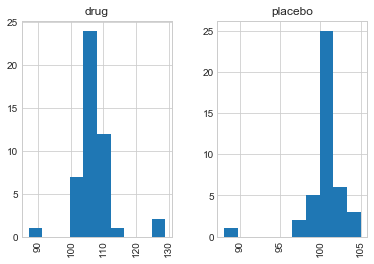

In [11]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug) 
y2 = np.array(placebo)
df = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group');

In [8]:
df.head()

,value,group
0,106,drug
1,105,drug
2,107,drug
3,109,drug
4,107,drug


In [30]:
tmodel = pm.Model()

with tmodel:
    
    loc_a = pm.Normal("loca", mu=df.value.mean(), sd=df.value.std() * 2)
    loc_b = pm.Normal("locb", mu=df.value.mean(), sd=df.value.std() * 2)
    
    scale_a = pm.HalfCauchy("scalea", 1)
    scale_b = pm.HalfCauchy("scaleb", 1)
    
    nu = pm.Exponential("pld_df", lam=4)
    
    treat = pm.StudentT("treat", nu=nu, mu=loc_a, sd=scale_a, observed=y1)
    control = pm.StudentT("control", nu=nu, mu=loc_b, sd=scale_b, observed=y2)
    
    meandiff = pm.Deterministic("meandiff", loc_a - loc_b)
    effectsize = pm.Deterministic("effectsize", meandiff/((scale_a + scale_b)/2))


In [31]:
with tmodel:
    trace = pm.sample(2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pld_df_log__, scaleb_log__, scalea_log__, locb, loca]
100%|██████████| 2500/2500 [00:02<00:00, 837.80it/s]


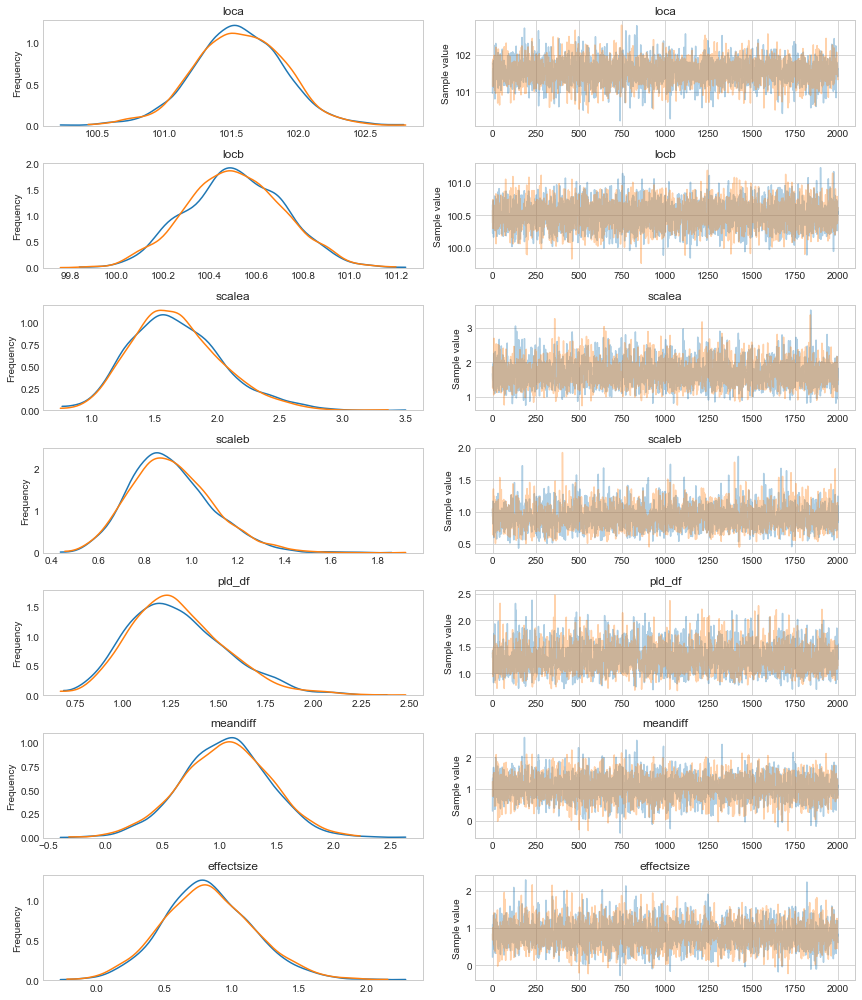

In [32]:
pm.traceplot(trace);

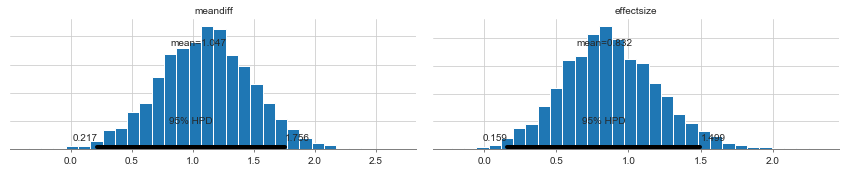

In [33]:
pm.plot_posterior(trace, varnames=["meandiff", "effectsize"]);

In [29]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
loca,101.549235,0.303048,0.004987,100.948978,102.106377,3102.0,1.000680
locb,100.454043,0.258897,0.006102,99.976691,100.905690,1486.0,1.000365
scalea,1.258919,0.295495,0.005391,0.717882,1.837605,2946.0,0.999976
scaleb,0.728488,0.187875,0.005452,0.298451,1.057229,1149.0,0.999974
pld_df,0.673411,0.106597,0.002311,0.465584,0.876473,1963.0,0.999776
meandiff,1.095191,0.404249,0.008123,0.313748,1.868307,2034.0,1.001252
effectsize,1.147897,0.504746,0.012703,0.275979,2.220749,1408.0,1.001002
